Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


Posterior Summary of Intercept and Betas:
            mean     sd  hdi_3%  hdi_97%
intercept -0.869  0.097  -1.048   -0.683
betas[0]   0.413  0.109   0.211    0.620
betas[1]   1.124  0.117   0.915    1.358
betas[2]  -0.256  0.102  -0.444   -0.065
betas[3]   0.011  0.110  -0.200    0.212
betas[4]  -0.134  0.105  -0.332    0.059
betas[5]   0.708  0.117   0.491    0.929
betas[6]   0.312  0.100   0.124    0.498
betas[7]   0.180  0.111  -0.028    0.390


Sampling: [likelihood]


KeyError: 'likelihood'

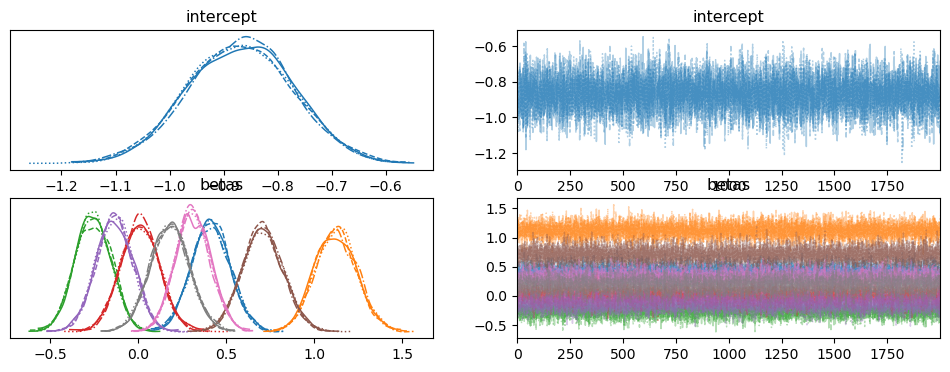

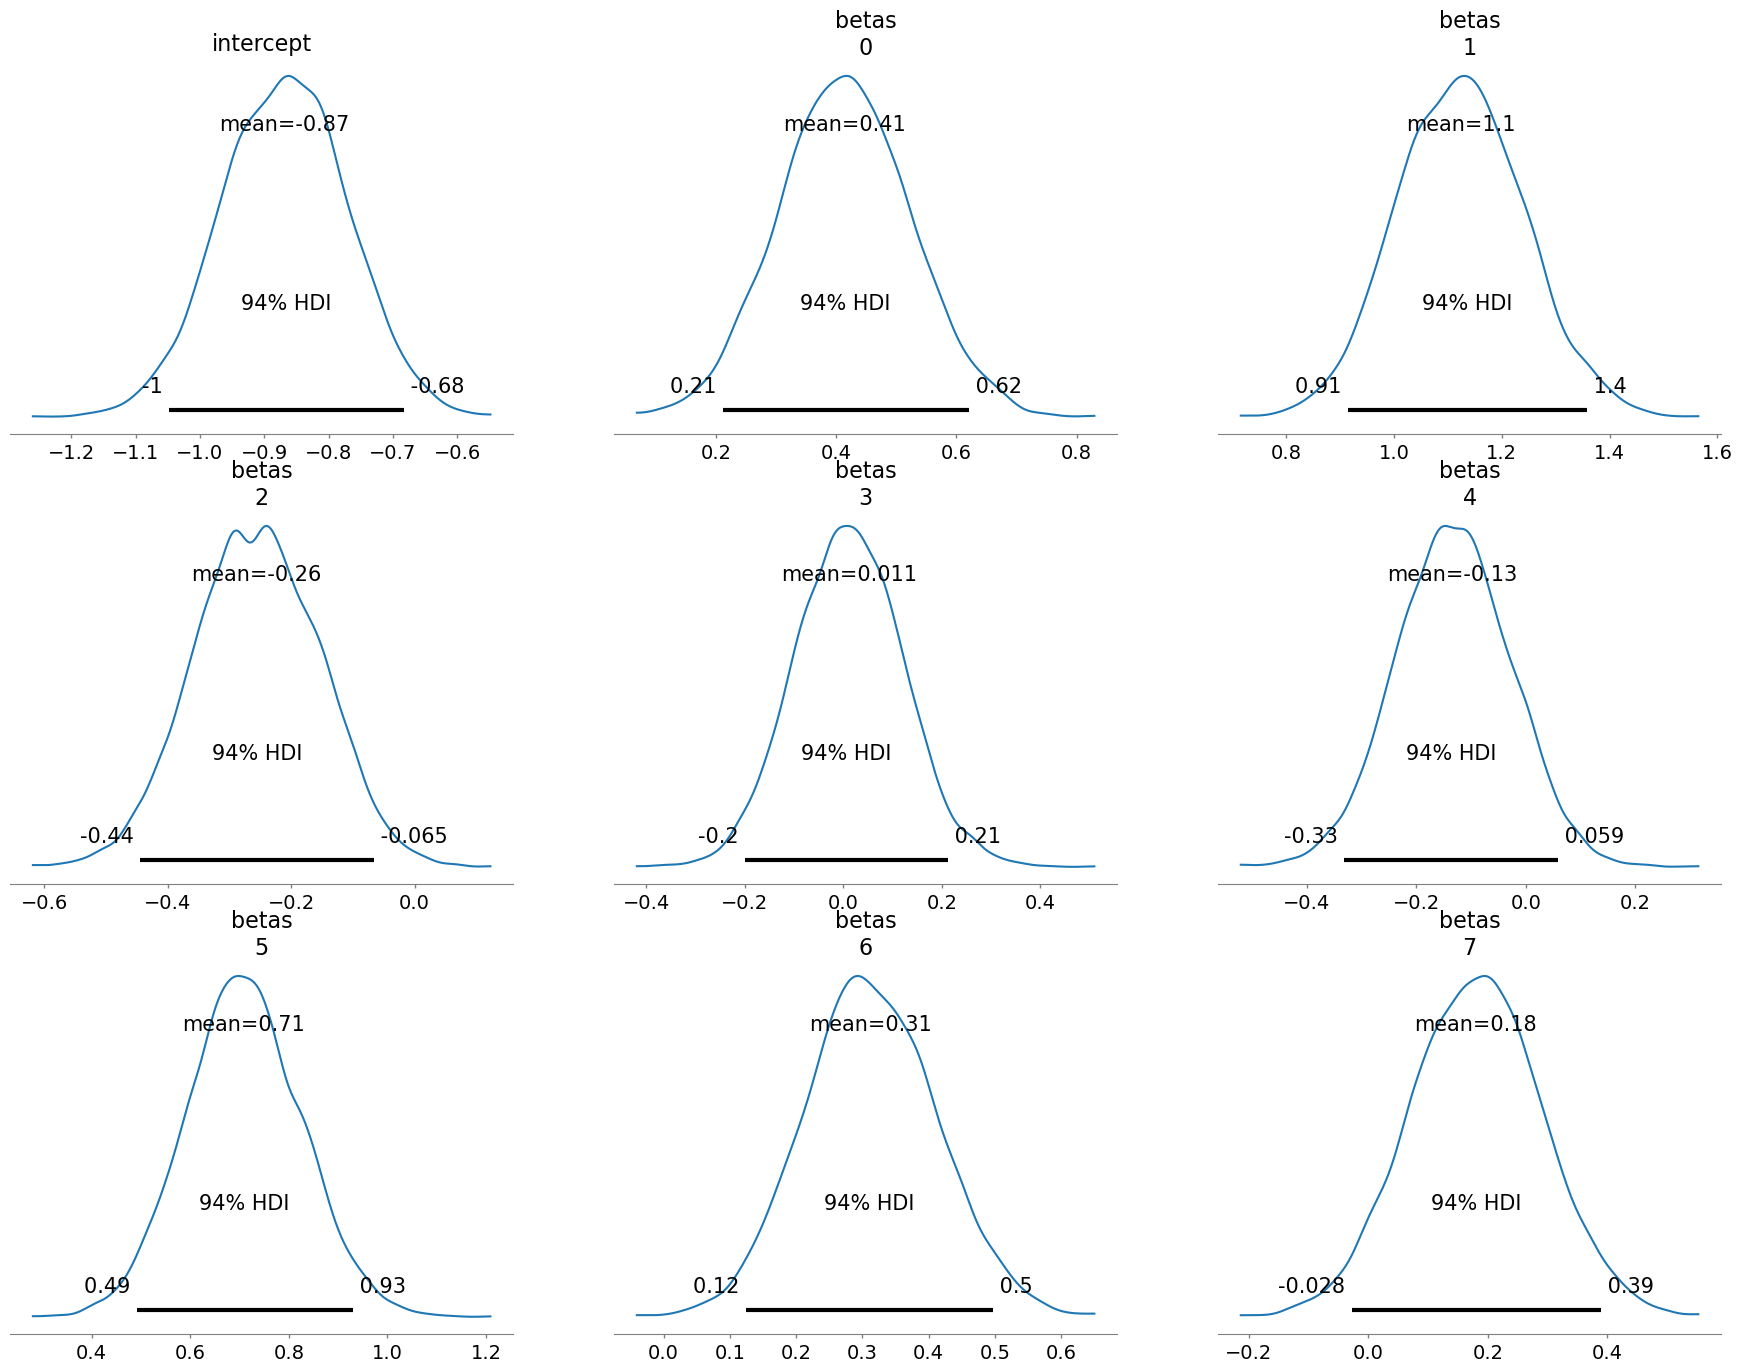

In [3]:
#Q1
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

# 1. LOAD AND PREPARE DATA
# --------------------------------------------------------------------
# Update the file name to match your CSV
df = pd.read_csv("diabetes_dataset.csv")

# Identify the outcome (target) column. Adjust if needed.
# If the column name is not "Outcome", change it here.
target_col = "Outcome"

# Separate predictors (X) from the outcome (y).
X = df.drop(columns=[target_col])
y = df[target_col].values

# Optional: standardize predictors to help MCMC converge more easily
X_mean = X.mean()
X_std = X.std()
X_norm = (X - X_mean) / X_std
X_data = X_norm.values

# Dimensions
n, p = X_data.shape

# 2. SPECIFY THE BAYESIAN LOGISTIC REGRESSION MODEL
# --------------------------------------------------------------------
"""
Inside the 'Model' context, we define:
 - intercept ~ Normal(0,1)
 - betas ~ Normal(0,1) for each predictor
 - a Bernoulli likelihood with logit_p = intercept + X•betas
"""

with pm.Model() as logistic_model:
    # Priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=p)
    
    # Linear predictor
    linear_combination = intercept + pm.math.dot(X_data, betas)
    
    # Bernoulli likelihood with logit link
    likelihood = pm.Bernoulli("likelihood",
                              logit_p=linear_combination,
                              observed=y)
    
    # 3. MCMC SAMPLING
    # ----------------------------------------------------------------
    trace = pm.sample(
        draws=2000,         # number of samples from the posterior
        tune=1000,          # number of warm-up (burn-in) iterations
        target_accept=0.9,  # aim for slightly higher acceptance rate
        random_seed=42
    )

# 4. CHECK MCMC DIAGNOSTICS & SUMMARIZE POSTERIOR
# --------------------------------------------------------------------
print("Posterior Summary of Intercept and Betas:")
summary_table = az.summary(trace, var_names=["intercept", "betas"], kind="stats")
print(summary_table)

# Plot the trace and posterior distributions
az.plot_trace(trace, var_names=["intercept", "betas"])
az.plot_posterior(trace, var_names=["intercept", "betas"])

# 5. OPTIONAL: POSTERIOR PREDICTIVE CHECK
# --------------------------------------------------------------------
"""
We sample from the posterior predictive distribution to assess how the model
predicts the observed data (rough check). A more thorough approach would
be train/test splits or cross-validation, but here's a basic illustration.
"""
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Mean predicted probability across posterior draws for each data point
preds_probability = ppc["likelihood"].mean(axis=0)

# Convert probability to hard classification (0 or 1)
threshold = 0.5
preds_hard = (preds_probability > threshold).astype(int)

accuracy = (preds_hard == y).mean()
print(f"Accuracy on training data: {accuracy:.3f}")



Columns in the CSV: ['Ptid', 'Persistency_Flag', 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket', 'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket', 'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx', 'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm', 'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx', 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms', 'Comorb_Encounter_For_Immunization', 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx', 'Comorb_Vitamin_D_Deficiency', 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified', 'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx', 'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia', 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions', 'Comorb_Other_Disorders_Of_Bone_Den

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


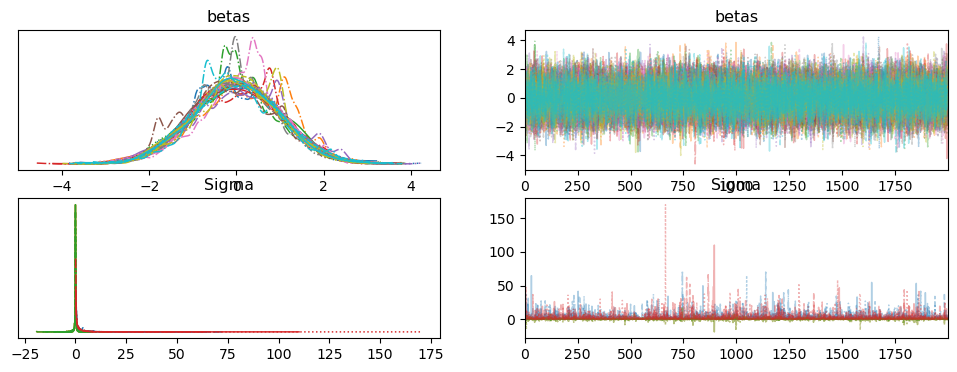

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0] -0.001  1.008  -1.893    1.838      0.015    0.014  4881.864   
betas[0, 1]  0.046  1.019  -1.844    1.921      0.033    0.015   940.861   
betas[1, 0] -0.024  1.001  -1.903    1.861      0.014    0.014  4794.783   
betas[1, 1] -0.010  1.016  -1.954    1.835      0.019    0.014  2825.236   
betas[2, 0]  0.046  1.024  -1.857    1.978      0.029    0.021  1193.245   
betas[2, 1] -0.051  0.998  -1.886    1.744      0.040    0.015   608.437   
betas[3, 0]  0.043  0.978  -1.811    1.888      0.015    0.015  4004.558   
betas[3, 1] -0.004  0.981  -1.819    1.880      0.014    0.013  4795.239   
betas[4, 0]  0.008  0.961  -1.833    1.768      0.016    0.012  3799.636   
betas[4, 1] -0.002  1.006  -1.917    1.846      0.022    0.018  2211.327   
Sigma[0, 0]  2.031  4.342   0.000    7.851      0.069    0.205  2103.987   
Sigma[0, 1] -0.004  0.954  -1.678    1.406      0.012    0.053  5734.391   
Sigma[1, 0] 

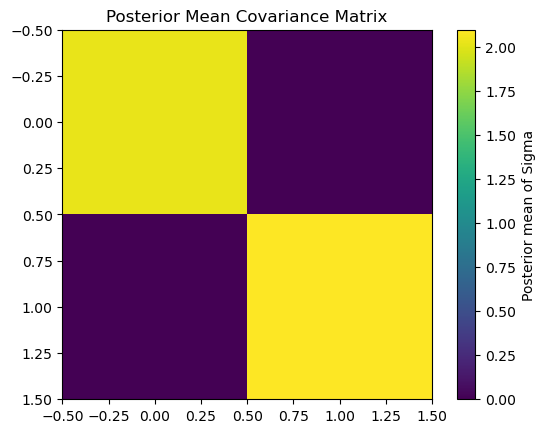

In [11]:
#Q2
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

#=========================
# 1. LOAD AND INSPECT DATA
#=========================
df = pd.read_csv("Persistent_vs_NonPersistent.csv")

print("Columns in the CSV:", df.columns.tolist())
print(df.head())   # quick peek at the data
print(df.dtypes)   # see which columns are object vs numeric

#-----------------------------------------------------
# CHOOSE TWO CONTINUOUS OUTCOME COLUMNS FOR MvNormal:
# Example: "Change_T_Score" and "Count_Of_Risks"
#-----------------------------------------------------
outcome_cols = ["Change_T_Score", "Count_Of_Risks"]

#-----------------------------------------------------
# CHOOSE PREDICTOR COLUMNS TO INCLUDE:
# Example: these 5 columns might be relevant or numeric.
# If any are "Y"/"N", we'll encode them below.
#-----------------------------------------------------
predictor_cols = [
    "Dexa_Freq_During_Rx",
    "Frag_Frac_Prior_Ntm",
    "Frag_Frac_During_Rx",
    "Change_Risk_Segment",
    "Idn_Indicator"
]

#=========================
# 2. ENSURE NUMERIC TYPES
#=========================
# If a column is "Y"/"N", encode as 1/0:
if "Idn_Indicator" in df.columns:
    df["Idn_Indicator"] = df["Idn_Indicator"].map({"Y": 1, "N": 0})

# Now convert everything in predictor_cols + outcome_cols to numeric
# (if something is non-numeric, it becomes NaN). 
for col in predictor_cols + outcome_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with NaN in those columns:
df = df.dropna(subset=predictor_cols + outcome_cols)

# Double-check that the columns are numeric now
print("\nDtypes after conversion:")
print(df[predictor_cols + outcome_cols].dtypes)

# Convert to NumPy arrays
X_full = df[predictor_cols].values  # shape (n, p)
Y_full = df[outcome_cols].values    # shape (n, m)
n = X_full.shape[0]
p = len(predictor_cols)
m = len(outcome_cols)

#=========================
# 3. OPTIONAL DOWNSAMPLING
#=========================
n_down = 500
if n > n_down:
    idx = np.random.choice(n, size=n_down, replace=False)
    X = X_full[idx, :]
    Y = Y_full[idx, :]
    n = n_down
else:
    X = X_full
    Y = Y_full

#========================================
# 4. BUILD & SAMPLE FROM THE PYMC MODEL
#========================================
with pm.Model() as model:
    # 4a. LKJ prior on covariance among the two outcomes
    packed_L = pm.LKJCholeskyCov(
        "packed_L",
        n=m,  # m=2 here, for two outcomes
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=m),
        compute_corr=False
    )
    L = pm.expand_packed_triangular(m, packed_L)  # (m x m)
    Sigma = pm.Deterministic("Sigma", L @ L.T)    # Full covariance

    # 4b. Normal(0,1) prior on betas => shape (p x m)
    betas = pm.Normal("betas", mu=0.0, sigma=1.0, shape=(p, m))

    # 4c. Multivariate Normal likelihood
    y_obs = pm.MvNormal(
        "y",
        mu=X @ betas,  # shape (n, m)
        chol=L,
        observed=Y     # shape (n, m)
    )

    # 5. Run MCMC sampling
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

#================================
# 6. POSTERIOR DIAGNOSTICS & PLOTS
#================================
az.plot_trace(idata, var_names=["betas", "Sigma"])
plt.show()

summary_df = az.summary(idata, var_names=["betas", "Sigma"], round_to=3)
print(summary_df)

post_Sigma_mean = idata.posterior["Sigma"].mean(dim=["chain","draw"]).values
plt.imshow(post_Sigma_mean)
plt.colorbar(label="Posterior mean of Sigma")
plt.title("Posterior Mean Covariance Matrix")
plt.show()



Initial dataset shape: (3424, 69)
  Ptid Persistency_Flag  Gender           Race     Ethnicity   Region  \
0   P1       Persistent    Male      Caucasian  Not Hispanic     West   
1   P2   Non-Persistent    Male          Asian  Not Hispanic     West   
2   P3   Non-Persistent  Female  Other/Unknown      Hispanic  Midwest   
3   P4   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest   
4   P5   Non-Persistent  Female      Caucasian  Not Hispanic  Midwest   

  Age_Bucket        Ntm_Speciality Ntm_Specialist_Flag  \
0        >75  GENERAL PRACTITIONER              Others   
1      55-65  GENERAL PRACTITIONER              Others   
2      65-75  GENERAL PRACTITIONER              Others   
3        >75  GENERAL PRACTITIONER              Others   
4        >75  GENERAL PRACTITIONER              Others   

       Ntm_Speciality_Bucket  ... Risk_Family_History_Of_Osteoporosis  \
0  OB/GYN/Others/PCP/Unknown  ...                                   N   
1  OB/GYN/Others/PCP/Unknown  ..

/opt/conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/conda/lib/python3.11/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, chol_cov, z]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1980 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.


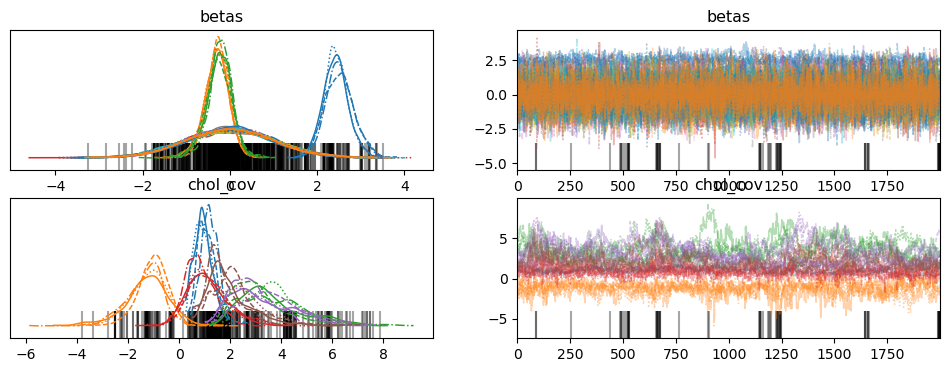

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
betas[0, 0]  2.473  0.308   1.898    3.076      0.020    0.008    252.756   
betas[0, 1] -0.297  0.276  -0.848    0.199      0.007    0.007   1546.773   
betas[0, 2] -0.242  0.291  -0.814    0.281      0.007    0.011   1874.492   
betas[1, 0] -0.016  1.009  -1.848    1.883      0.011    0.015   9147.795   
betas[1, 1] -0.002  1.002  -1.828    1.911      0.009    0.013  12110.692   
betas[1, 2]  0.010  1.028  -1.887    1.947      0.010    0.013  10495.440   
betas[2, 0] -0.006  0.986  -1.869    1.788      0.010    0.012   9506.615   
betas[2, 1]  0.001  0.983  -1.894    1.815      0.009    0.012  10982.637   
betas[2, 2] -0.002  1.023  -1.914    1.879      0.011    0.013   8428.630   
betas[3, 0] -0.011  1.003  -1.806    1.990      0.011    0.014   8492.344   
betas[3, 1] -0.004  0.996  -1.925    1.808      0.010    0.014  10310.727   
betas[3, 2]  0.009  1.010  -1.970    1.883      0.009    0.014  11376.449   

In [30]:
#Q3
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#=====================================================
# 1. Load the dataset
#=====================================================
df = pd.read_csv("Persistent_vs_NonPersistent.csv")

# Peek at dataset
print("Initial dataset shape:", df.shape)
print(df.head())

#--------------------------------------------------------------------------------------
# Define multiple binary outcome columns
# Ensure these are mapped to 0/1 correctly
#--------------------------------------------------------------------------------------
binary_outcomes = ["Persistency_Flag", "Adherent_Flag", "Idn_Indicator"]

# Print unique values before encoding
for col in binary_outcomes:
    print(f"\nUnique values in {col} before mapping:", df[col].unique())

# Correct mapping for each binary outcome column
binary_mappings = {
    "Persistency_Flag": {"Non-Persistent": 0, "Persistent": 1},
    "Adherent_Flag": {"Non-Adherent": 0, "Adherent": 1},
    "Idn_Indicator": {"N": 0, "Y": 1},
}

# Apply mappings and ensure no missing values
for col in binary_outcomes:
    df[col] = df[col].map(binary_mappings[col])

    # If column is all NaN after mapping, fill with 0
    if df[col].isna().all():
        print(f"⚠ Warning: {col} has all NaN after mapping. Filling with 0.")
        df[col] = 0

    # Ensure column is integer type
    df[col] = df[col].fillna(df[col].mode().iloc[0]).astype(int)

#--------------------------------------------------------------------------------------
# Define predictor columns (Ensure numeric format)
#--------------------------------------------------------------------------------------
predictor_cols = [
    "Dexa_Freq_During_Rx",
    "Frag_Frac_Prior_Ntm",
    "Frag_Frac_During_Rx",
    "Change_Risk_Segment"
]

# Print missing values in predictors before handling
print("\nMissing values per predictor before handling:")
print(df[predictor_cols].isna().sum())

# Convert to numeric and handle missing values
for col in predictor_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Fill missing numeric values with the median
df[predictor_cols] = df[predictor_cols].fillna(df[predictor_cols].median())

# Print dataset shape after filling missing values
print("\nDataset shape after filling missing values:", df.shape)

# Ensure dataset is not empty
if df.shape[0] == 0:
    raise ValueError("❌ ERROR: No valid rows remain after preprocessing!")

#=====================================================
# 2. Split dataset into X (features) and Y (binary targets)
#=====================================================
X_full = df[predictor_cols].values  # shape (n, p)
Y_full = df[binary_outcomes].values  # shape (n, m)

#=====================================================
# 3. Train/Test Split
#=====================================================
X_train, X_test, Y_train, Y_test = train_test_split(
    X_full, Y_full, test_size=0.2, random_state=42
)

print("\nTrain shapes:", X_train.shape, Y_train.shape)
print("Test  shapes:", X_test.shape, Y_test.shape)

#=====================================================
# 4. Scale Features (Standardization)
#=====================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensure No NaNs in Standardized Features
X_train_scaled = np.nan_to_num(X_train_scaled)
X_test_scaled = np.nan_to_num(X_test_scaled)

print("\nChecking for NaNs in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("Checking for NaNs in X_test_scaled:", np.isnan(X_test_scaled).sum())

#=====================================================
# 5. (Optional) Downsampling for faster training
#=====================================================
n_train = X_train_scaled.shape[0]
n_down = 500  # Reduce training size if dataset is too large
if n_train > n_down:
    idx = np.random.choice(n_train, size=n_down, replace=False)
    X_train_scaled = X_train_scaled[idx, :]
    Y_train = Y_train[idx, :]
    n_train = n_down

# Check for NaNs in Y_train
print("Checking for NaNs in Y_train:", np.isnan(Y_train).sum())

#=====================================================
# 6. Build the Bayesian Multivariate Classification Model
#=====================================================
n_features = X_train_scaled.shape[1]  # Number of predictors (p)
n_targets = Y_train.shape[1]          # Number of binary outcome variables (m)

with pm.Model() as multivariate_classification_model:

    # 6a. Priors for regression coefficients (betas)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(n_features, n_targets))
    
    # 6b. Use compute_corr=True so we get a 2D Cholesky factor back
    chol_cov, _, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=n_targets,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0, shape=n_targets),
        compute_corr=True  # <--- THIS ensures `chol_cov` is 2D
    )

    # 6c. Latent multivariate normal variable (z)
    #     We have n_train rows, each is a length-n_targets vector
    linear_combination = pm.math.dot(X_train_scaled, betas)  # shape (n_train, n_targets)
    z = pm.MvNormal(
        "z",
        mu=linear_combination, 
        chol=chol_cov,            # 2D => shape (n_targets, n_targets)
        shape=(n_train, n_targets) 
    )
    
    # 6d. Link function: Convert latent variable into binary probability via sigmoid
    p = pm.math.sigmoid(z)
    
    # 6e. Bernoulli likelihood (multi-output classification)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=Y_train)
    
    # 6f. Sample from the posterior
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

#=====================================================
# 7. Posterior Analysis & Diagnostics
#=====================================================
az.plot_trace(idata, var_names=["betas", "chol_cov"])
plt.show()

summary_df = az.summary(idata, var_names=["betas", "chol_cov"], round_to=3)
print(summary_df)

# Posterior samples of the 2D Cholesky factor
post_chol = idata.posterior["chol_cov"]
print("\nPosterior samples of Cholesky factors:\n", post_chol)
